In [1]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [87]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs))
    dpi = math.log2(num)
    return - npi/dpi

def fairness(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    return npi/dpi

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairness(values_list[2]))

0.7556018366014379
0.40584415584415584


In [2]:
import os

PATH = "../blockchainnode/db_nodes"
fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
fdbs.sort()
print(fdbs)

['../blockchainnode/db_nodes/7031.db', '../blockchainnode/db_nodes/7032.db', '../blockchainnode/db_nodes/7033.db', '../blockchainnode/db_nodes/7034.db', '../blockchainnode/db_nodes/7035.db', '../blockchainnode/db_nodes/7036.db', '../blockchainnode/db_nodes/7037.db', '../blockchainnode/db_nodes/7038.db']


[13, 18, 16, 18, 13, 13, 10, 16]
[19, 14, 13, 13, 21, 21, 6, 10]
Fairness Proof 0.9683786078098472
Fairness Verification 0.8944720334553058
Entropy Proof 0.991962798242048
Entropy Verification 0.9698041599585382


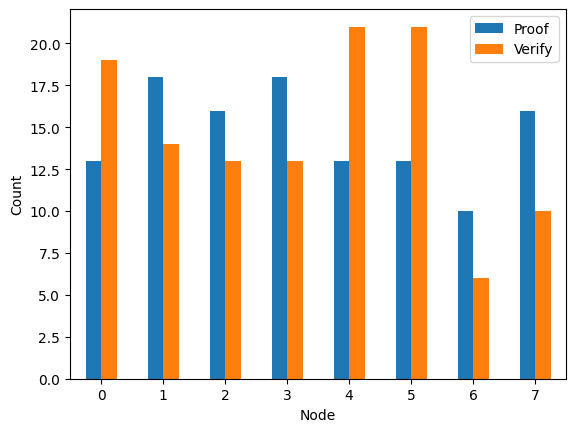

In [88]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif)

ch_list = [proof, verif]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Count")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairness(proof))
print('Fairness Verification', fairness(verif))

print('Entropy Proof', entropynorm(proof))
print('Entropy Verification', entropynorm(verif))




[25.004615384615384, 33.33383333333333, 23.2166875, 41.10377777777778, 21.023692307692308, 59.11276923076923, 32.6661, 21.2571875]
[8491.01852631579, 8127.106785714286, 8788.332923076923, 9164.824384615385, 8064.109476190476, 9677.095142857144, 12191.7685, 10346.29]
[1560.0632105263157, 1582.6208571428572, 1852.8218461538463, 1954.478769230769, 1590.3156666666669, 1599.3211904761906, 1926.48, 1824.25]


Text(0, 0.5, 'Time[msec]')

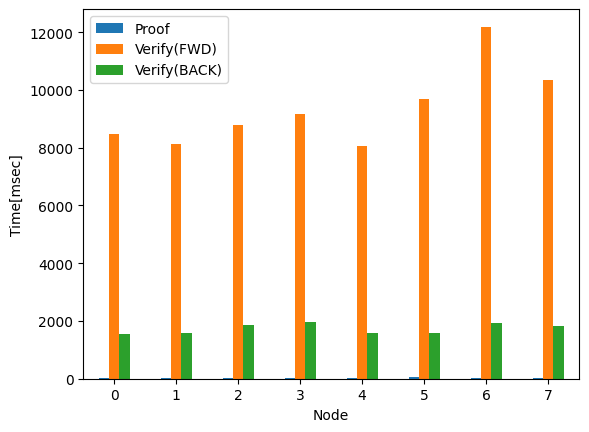

In [86]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    verifrev.append(df['timeverifrev'].mean()/unit)
print(veriffwd)
print(verifrev)

ch_list = [proof, veriffwd, verifrev]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify(FWD)', 'Verify(BACK)']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Time[msec]")

[0.9793221538461538, 1.040577111111111, 0.940267, 0.8722842352941176, 0.9306249230769231, 1.4027984615384614, 0.9238531999999999, 0.97630875]


Text(0, 0.5, 'Size[MByte]')

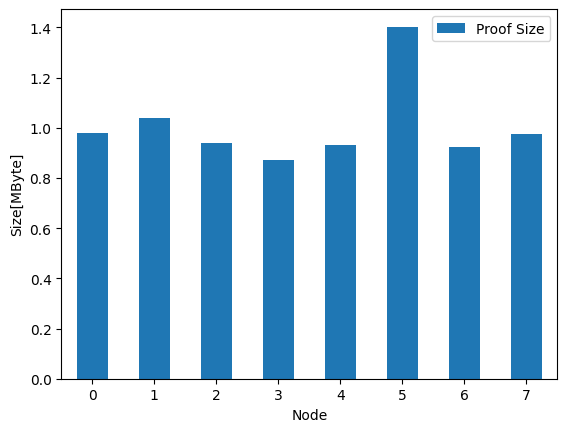

In [85]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Size[MByte]")

Text(0, 0.5, 'Count')

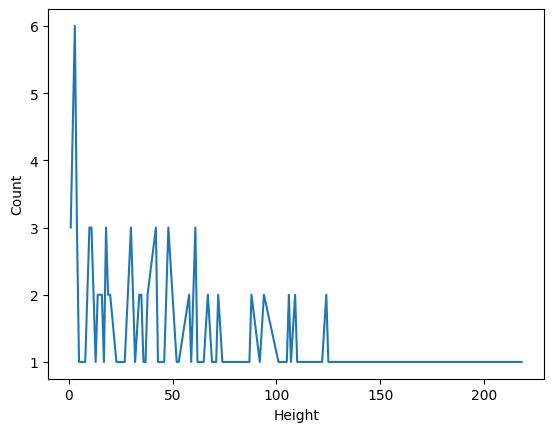

In [84]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
# print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
# print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Hash', 'Height']
bdf = bdf.sort_values(by=['Height'])
bdf2 = bdf.groupby(['Height'])['Height'].count()

# print(bdf2)
ax = bdf2.plot.line(rot=0)
plt.xlabel("Height")
plt.ylabel("Count")